In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

import random
from grid import *
from wfc import *
from utils import *
from floor import *
import cv2 as cv
import os

file calledfloor_10_small.png
file calledfloor_11_small.png
file calledfloor_1_small.png
file calledfloor_2_small.png
file calledfloor_3_small.png
file calledfloor_4_small.png
file calledfloor_5_small.png
file calledfloor_6_small.png
file calledfloor_7_small.png
file calledfloor_8_small.png
file calledfloor_9_small.png


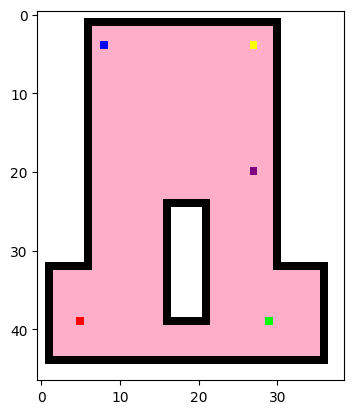

In [2]:
floorplans = []
data_dir = "data/pre_defined/small/"
for filename in os.listdir(data_dir):
    if filename.lower().endswith(('.png', 'jpeg')):
        print(f"file called{filename}")
        filepath = os.path.join(data_dir, filename)
        floorplan = cv.imread(filepath)
        floorplan = cv.cvtColor(floorplan, cv.COLOR_BGR2RGB)
        plt.imshow(floorplan)
        floorplans.append(floorplan)

In [3]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

def extract_wall_segments(grid):
    """
    Scan a 2D grid and return wall segments for blueprint plotting.
    Handles values 1 and 18 as wall tiles.
    """
    grid = np.asarray(grid)
    rows, cols = grid.shape

    horiz = defaultdict(dict)
    vert = defaultdict(dict)

    for r in range(rows):
        start = None
        for c in range(cols - 1):
            if grid[r, c] == 1 and grid[r, c + 1] == 1:
                if start is None:
                    start = c  # Start of a new segment
            else:
                if start is not None:
                    end = c - 1 # End the current segment at previous c
                    horiz[r][start] = end
                    start = None
        if start is not None:
            end = cols - 2  # Last possible c is cols-2
            horiz[r][start] = end

    for c in range(cols):
        start = None
        for r in range(rows - 1):
            if grid[r, c] == 1 and grid[r + 1, c] == 1:
                if start is None:
                    start = r  # Start of a new segment
            else:
                if start is not None:
                    # End the current segment at previous r
                    end = r - 1
                    vert[c][start] = end
                    start = None
        if start is not None:
            end = rows - 2  # Last possible r is rows-2
            vert[c][start] = end

    return horiz, vert

def plot_blueprint_walls(horiz, vert, rows, cols, line_color='#1f77b4', line_width=2):
    """Improved plotting function with better grid handling"""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(rows - 0.5, -0.5)
    
    for row, segments in horiz.items():
        for start, end in segments.items():
            ax.plot([start, end + 1], [row, row], color=line_color, 
                    linewidth=line_width, solid_capstyle='butt')
    
    for col, segments in vert.items():
        for start, end in segments.items():
            ax.plot([col, col], [start, end + 1], color=line_color, 
                    linewidth=line_width, solid_capstyle='butt')
    
    ax.set_xticks(np.arange(cols))
    ax.set_yticks(np.arange(rows))
    #ax.grid(True, color='lightgray', linestyle='--')
    
    plt.title("Blueprint Walls", pad=20)
    plt.tight_layout()
    plt.show()

In [4]:
"""
grid_simple = [
    [0, 0, ],
    [0, 0]
]
fp = FloorPlan(np.array(grid_simple), seeds=[])
    # Optionally plot the floorplan with seed locations
    # plot_floorplan(floorplan_int, seed_list)
    

fp.show()
fp.generate_wfc()


fp.show()

"""

'\ngrid_simple = [\n    [0, 0, ],\n    [0, 0]\n]\nfp = FloorPlan(np.array(grid_simple), seeds=[])\n    # Optionally plot the floorplan with seed locations\n    # plot_floorplan(floorplan_int, seed_list)\n    \n\nfp.show()\nfp.generate_wfc()\n\n\nfp.show()\n\n'

(30, 39, 3)
(35, 3, 144)
(3, 4, 128)
(34, 17, 132)
(3, 26, 129)
(20, 26, 130)


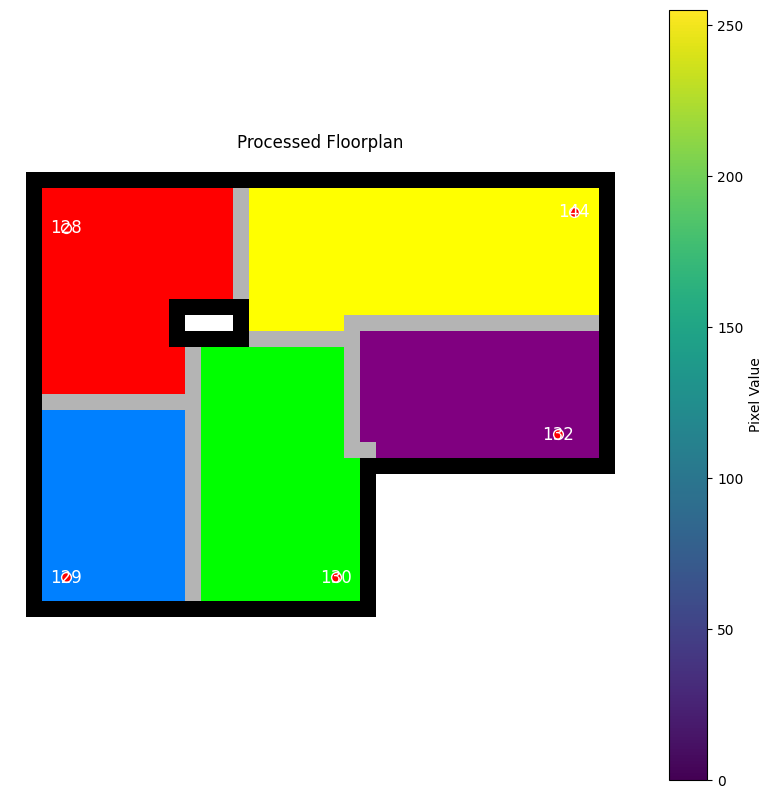

[(1, 1), (1, 37), (9, 10), (9, 14), (11, 10), (11, 14), (19, 22), (19, 37), (28, 1), (28, 22)]
{128: [(12, 1), (3, 1), (14, 1), (5, 1), (9, 14), (1, 6), (9, 11), (1, 3), (1, 9), (11, 11), (13, 11), (2, 14), (1, 12), (15, 2), (15, 5), (7, 1), (15, 8), (15, 11), (6, 14), (15, 9), (4, 14), (9, 1), (9, 10), (11, 1), (8, 14), (1, 2), (9, 13), (2, 1), (11, 10), (1, 5), (1, 11), (6, 1), (13, 1), (1, 8), (1, 14), (15, 1), (15, 4), (15, 7), (15, 10), (12, 11), (4, 1), (14, 11), (3, 14), (8, 1), (5, 14), (9, 12), (10, 1), (1, 4), (10, 10), (1, 7), (1, 13), (15, 6), (1, 10), (15, 3), (7, 14)], 129: [(20, 11), (23, 1), (22, 11), (27, 1), (28, 3), (28, 9), (28, 6), (25, 1), (15, 2), (24, 11), (16, 1), (15, 5), (15, 11), (26, 11), (18, 1), (15, 8), (22, 1), (20, 1), (28, 2), (28, 5), (17, 11), (28, 11), (28, 8), (19, 11), (26, 1), (24, 1), (15, 4), (15, 1), (15, 7), (15, 10), (23, 11), (21, 11), (28, 4), (17, 1), (28, 1), (28, 7), (27, 11), (19, 1), (28, 10), (15, 6), (15, 3), (15, 9), (25, 11), (18

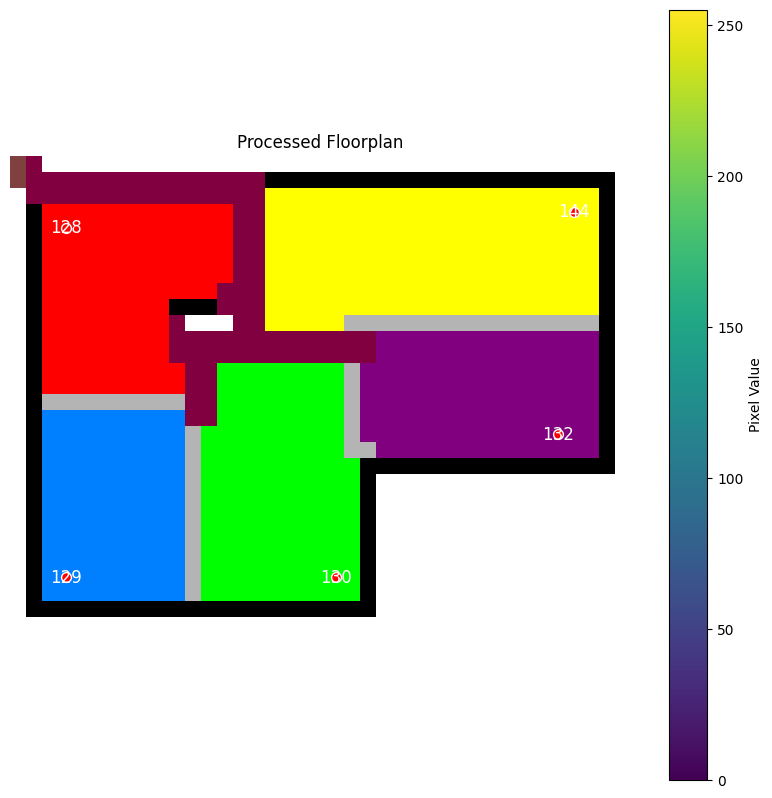

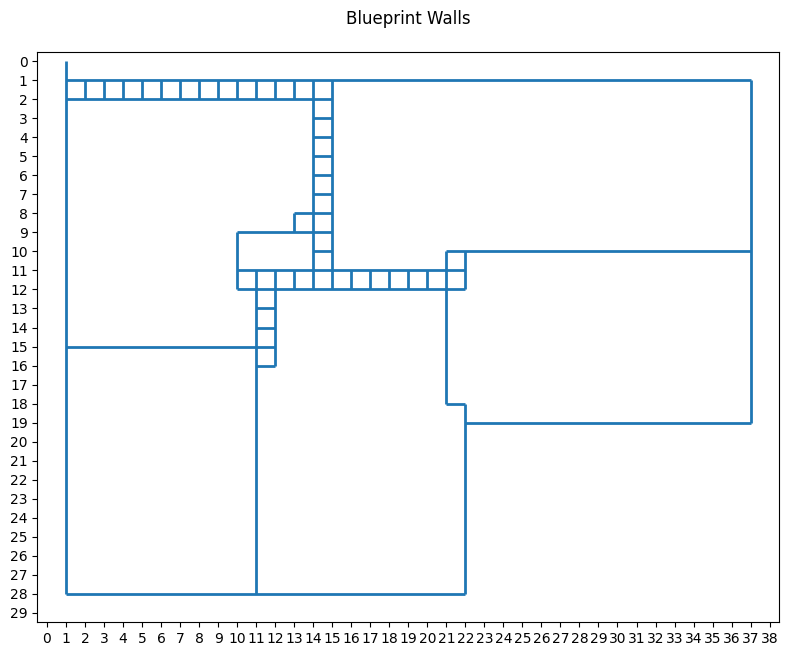

(27, 31, 3)
(14, 2, 132)
(2, 4, 130)
(27, 15, 129)
(3, 24, 128)
(15, 24, 144)


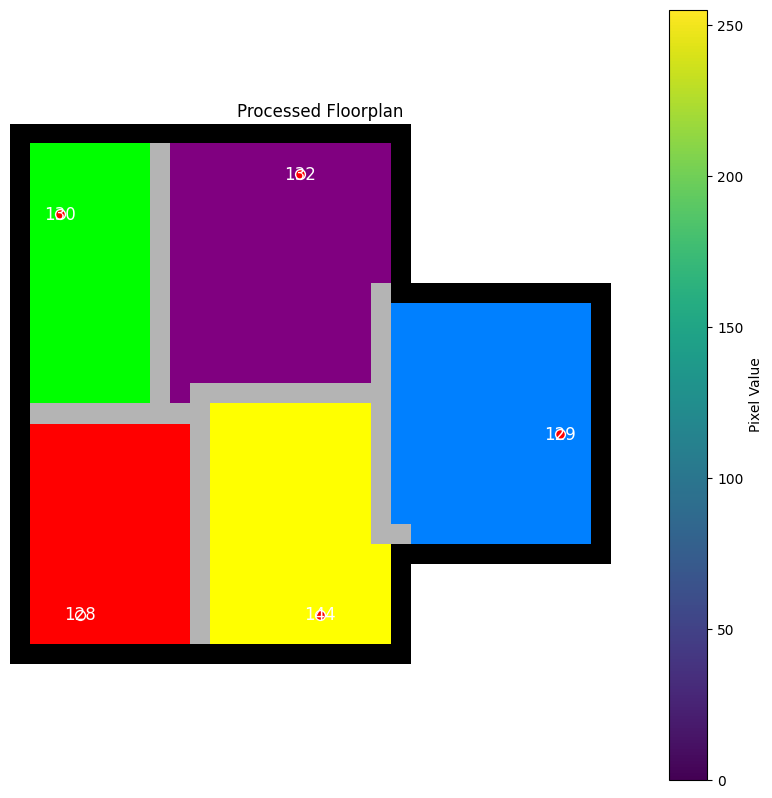

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (8, 19), (8, 29), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (21, 19), (21, 29), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (26, 1), (26, 2), (26, 3), (26, 4), (26, 5), (26, 6), (26, 7), (26, 8), (26, 9), (26, 10), (26, 11), (26, 12), (26, 13), (26, 14), (26, 15), (26, 16), (26, 17), (26, 18), (26, 19)]
{128: [(14, 4), (14, 1), (14, 7), (17, 0), (17, 9), (19, 0), (19, 9), (26, 2), (26, 5), (21, 0), (26, 8), (21, 9), (23, 0), (14, 0), (14, 6), (23, 9), (14, 3), (14, 9), (26, 9), (25, 0), (26, 1), (16, 0), (25, 9), (26, 4), (16, 9), (18, 0), (26, 7), (18, 9), (20, 0), (20, 9), (22, 0), (14, 2), (22, 9), (14, 5), (14, 8), (24, 0), (15, 0), (24, 9), (26, 0), (26, 6), (26, 3), (15, 9)],

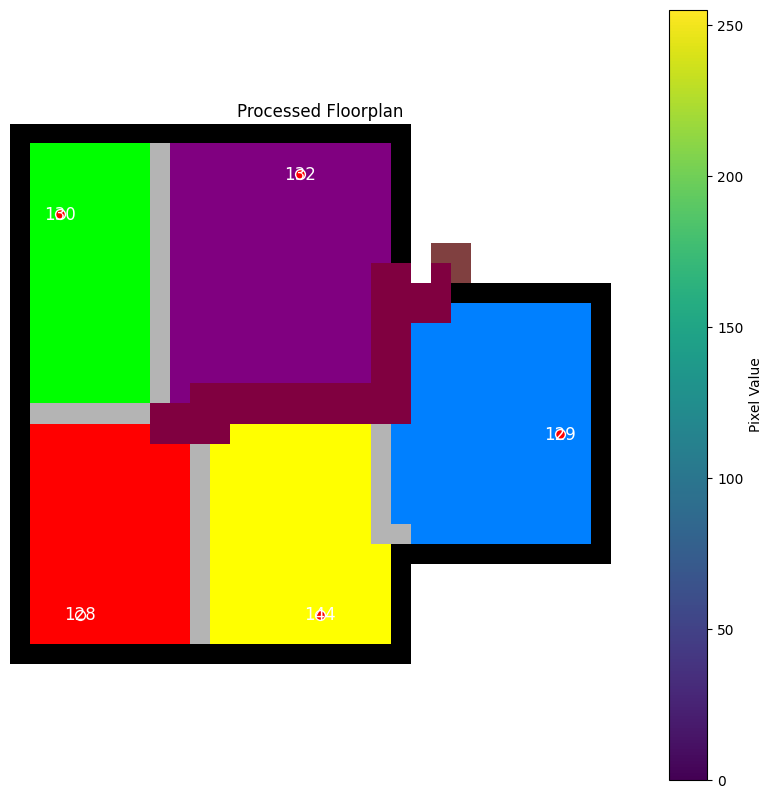

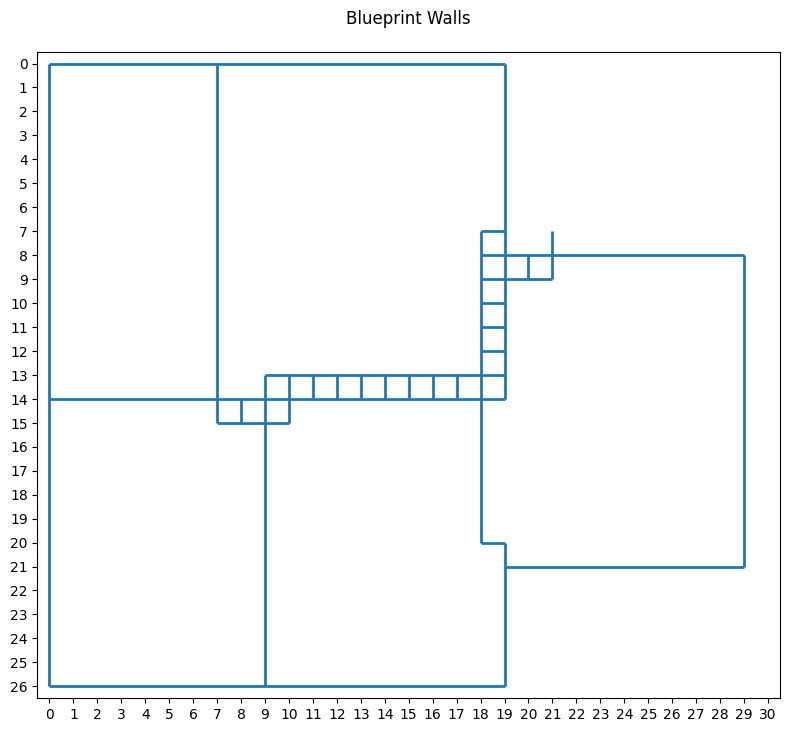

(38, 55, 3)
(15, 8, 128)
(29, 9, 144)
(42, 14, 129)
(11, 25, 130)
(27, 26, 132)


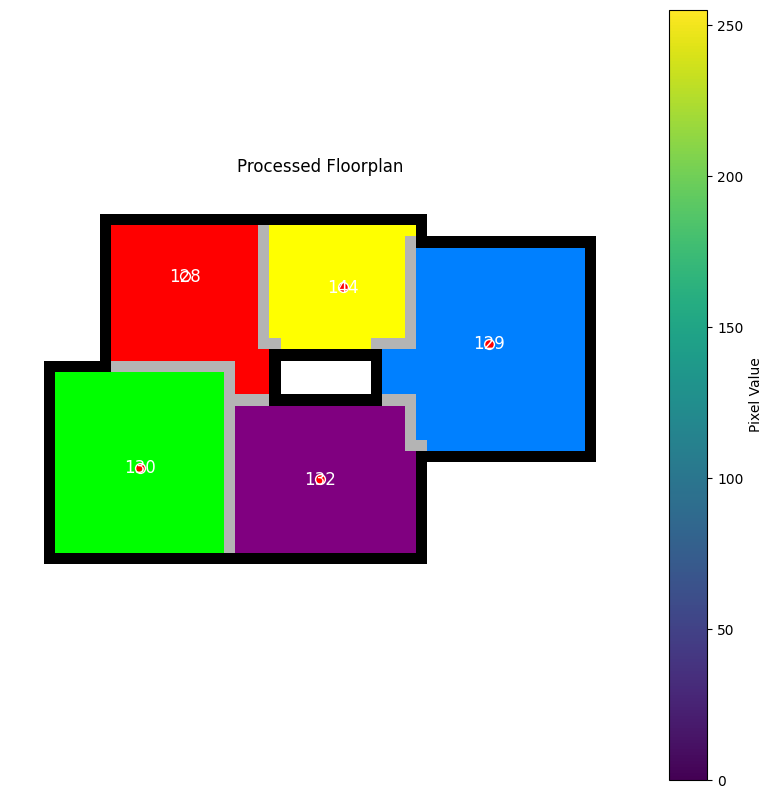

[(3, 8), (3, 36), (5, 36), (5, 51), (15, 23), (15, 32), (16, 3), (16, 8), (19, 23), (19, 32), (24, 36), (24, 51), (33, 3), (33, 36)]
{128: [(18, 23), (16, 17), (3, 10), (3, 16), (3, 13), (3, 19), (12, 22), (9, 8), (3, 22), (14, 22), (11, 8), (5, 22), (16, 14), (19, 21), (13, 8), (16, 10), (15, 8), (16, 16), (16, 13), (16, 19), (6, 8), (15, 23), (18, 19), (7, 22), (3, 9), (4, 8), (3, 12), (3, 18), (3, 15), (3, 21), (8, 8), (17, 23), (10, 8), (19, 23), (9, 22), (19, 20), (16, 9), (11, 22), (16, 12), (16, 15), (13, 22), (16, 18), (12, 8), (6, 22), (3, 11), (3, 8), (3, 14), (14, 8), (5, 8), (3, 17), (14, 23), (4, 22), (3, 20), (17, 19), (19, 19), (8, 22), (19, 22), (16, 8), (10, 22), (16, 11), (7, 8), (16, 23)], 129: [(5, 50), (24, 36), (24, 42), (9, 51), (16, 32), (24, 39), (7, 35), (24, 45), (11, 51), (18, 32), (24, 48), (24, 51), (15, 51), (20, 35), (13, 51), (6, 51), (22, 35), (14, 34), (5, 37), (9, 35), (5, 40), (19, 33), (5, 43), (5, 49), (11, 35), (19, 34), (5, 46), (13, 35), (15, 3

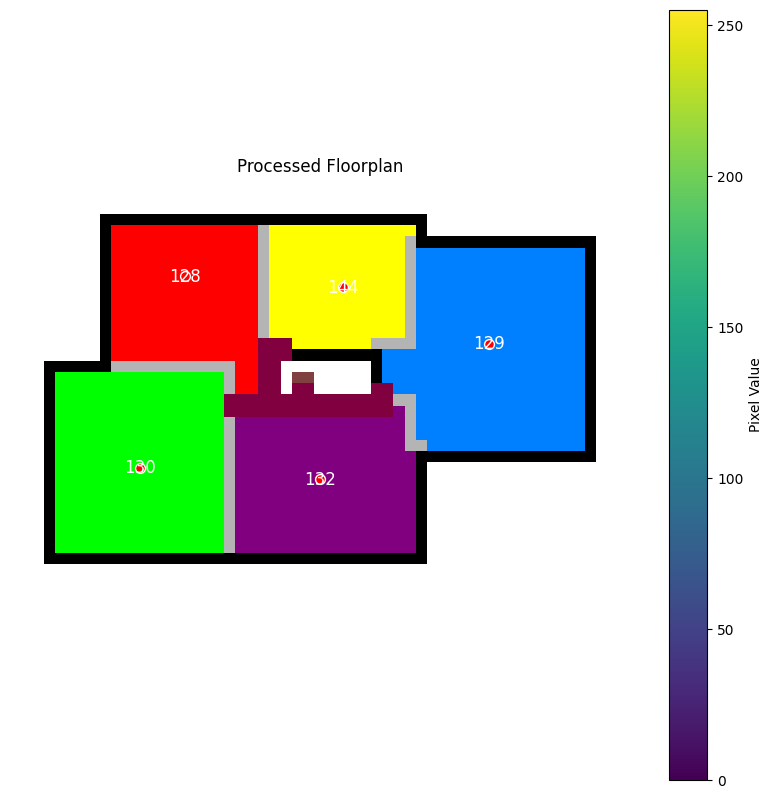

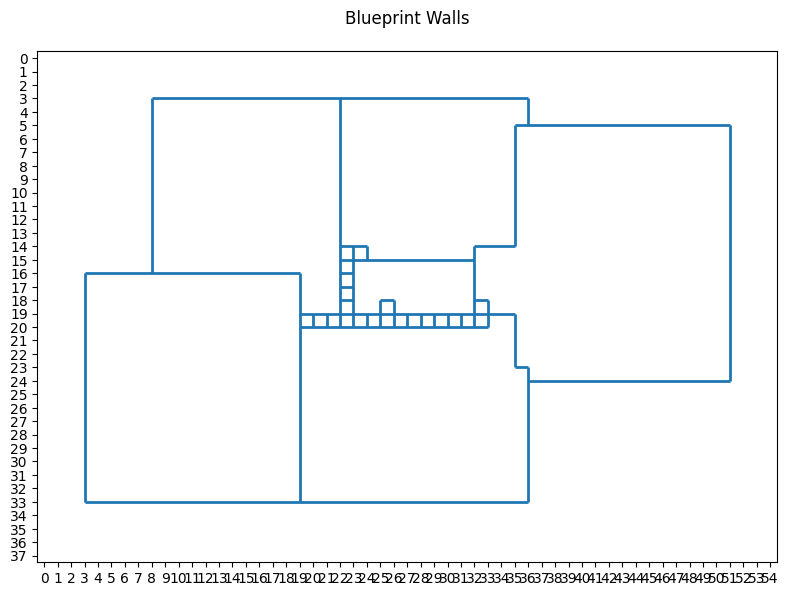

(43, 62, 3)
(52, 6, 128)
(14, 8, 144)
(37, 21, 132)
(6, 22, 130)
(49, 34, 129)


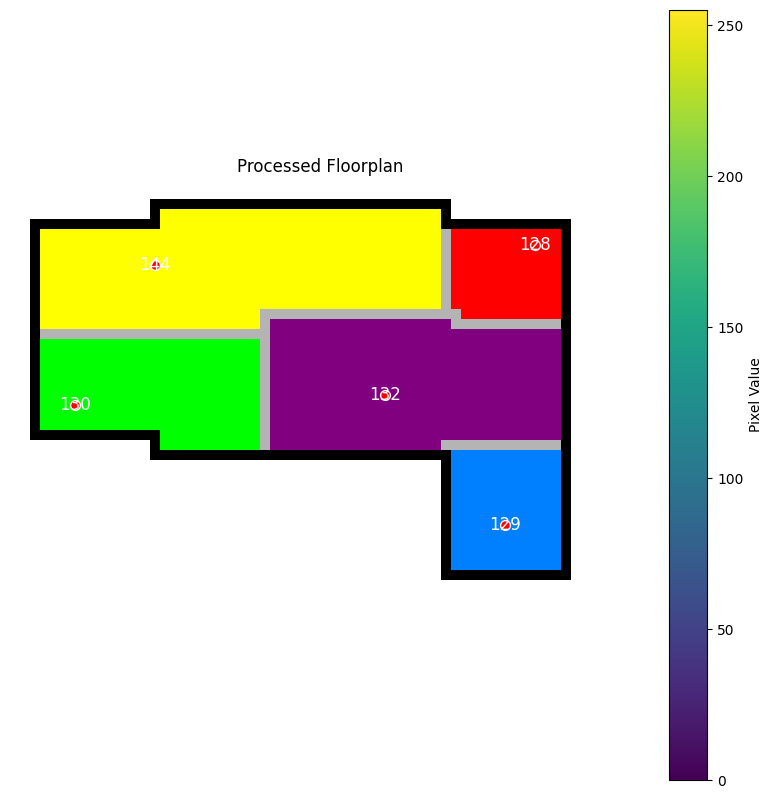

[(2, 14), (2, 43), (4, 2), (4, 14), (4, 43), (4, 55), (25, 2), (25, 14), (27, 14), (27, 43), (39, 43), (39, 55)]
{128: [(4, 49), (4, 55), (14, 53), (8, 43), (10, 43), (8, 55), (10, 55), (12, 43), (4, 45), (14, 49), (4, 48), (4, 54), (5, 43), (12, 55), (4, 51), (14, 46), (14, 52), (14, 55), (5, 55), (13, 44), (7, 43), (7, 55), (4, 47), (14, 45), (14, 51), (4, 44), (4, 50), (14, 48), (14, 54), (4, 53), (9, 43), (11, 43), (9, 55), (13, 43), (11, 55), (13, 55), (6, 43), (6, 55), (14, 44), (4, 43), (14, 47), (4, 46), (4, 52), (14, 50)], 129: [(37, 55), (30, 43), (28, 55), (32, 43), (30, 55), (26, 45), (26, 51), (32, 55), (26, 48), (26, 54), (39, 45), (39, 51), (39, 48), (39, 54), (34, 43), (36, 43), (34, 55), (27, 43), (36, 55), (27, 55), (26, 44), (38, 43), (26, 47), (39, 44), (26, 50), (29, 43), (39, 47), (39, 53), (26, 53), (31, 43), (38, 55), (39, 50), (29, 55), (31, 55), (33, 43), (35, 43), (26, 46), (33, 55), (26, 43), (26, 49), (39, 46), (35, 55), (26, 52), (39, 43), (39, 49), (26, 5

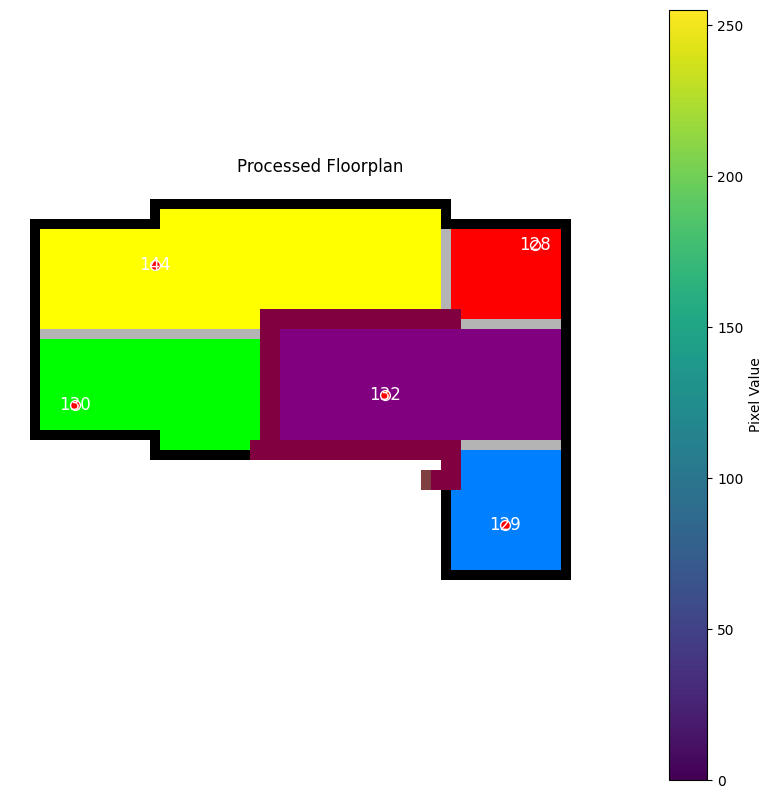

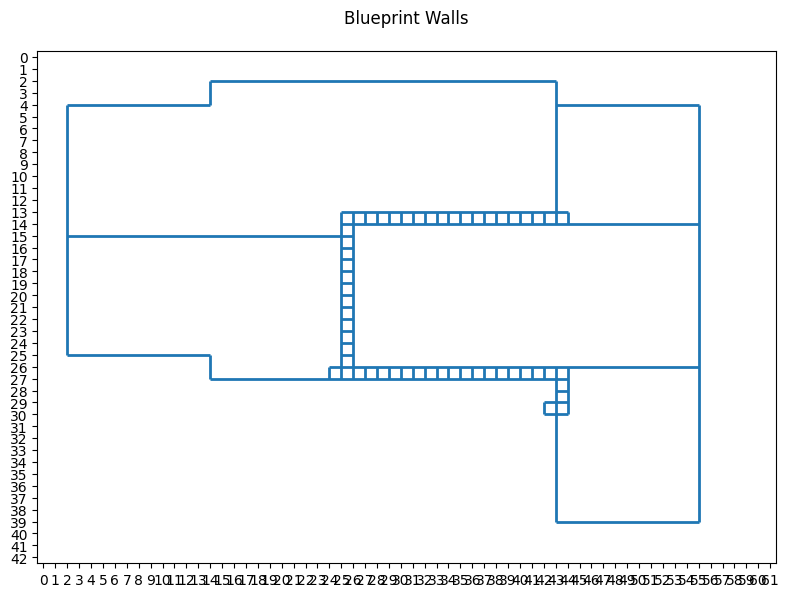

(33, 46, 3)
(17, 4, 144)
(36, 5, 132)
(8, 14, 129)
(8, 26, 128)
(36, 27, 130)


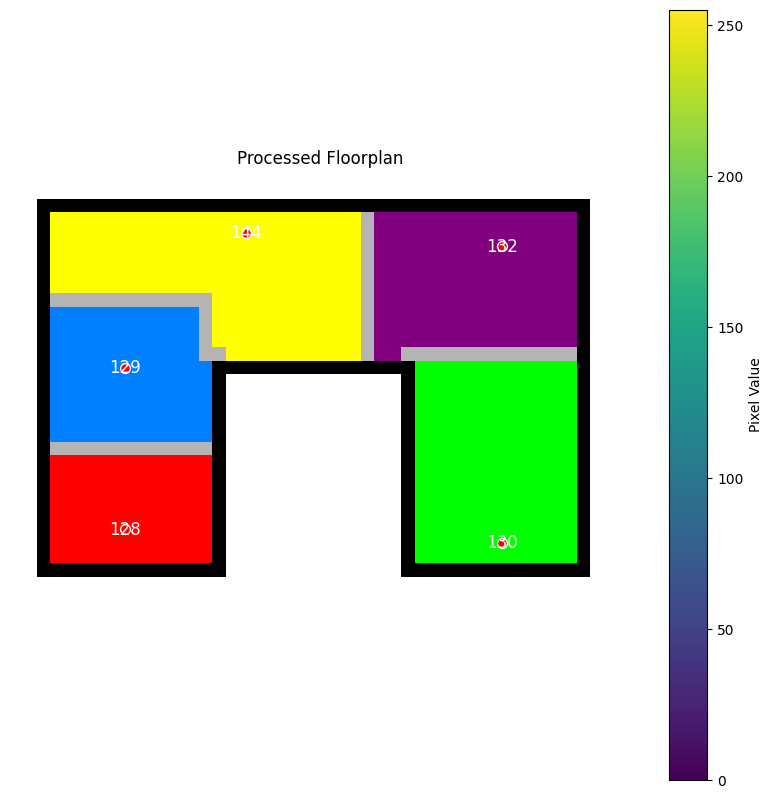

[(2, 2), (2, 42), (14, 15), (14, 29), (29, 2), (29, 15), (29, 29), (29, 42)]
{128: [(20, 5), (22, 2), (20, 11), (29, 14), (20, 8), (20, 14), (28, 15), (24, 2), (26, 2), (29, 4), (29, 7), (20, 4), (29, 10), (20, 7), (20, 13), (29, 13), (20, 10), (21, 15), (28, 2), (23, 15), (29, 11), (27, 15), (29, 8), (29, 6), (25, 15), (21, 2), (29, 3), (20, 6), (29, 9), (20, 3), (20, 9), (23, 2), (29, 12), (29, 15), (20, 12), (20, 15), (27, 2), (22, 15), (25, 2), (29, 2), (24, 15), (29, 5), (20, 2), (26, 15)], 129: [(20, 5), (20, 11), (20, 8), (20, 14), (9, 2), (9, 5), (11, 2), (9, 8), (9, 14), (17, 15), (13, 2), (9, 11), (11, 14), (19, 15), (15, 2), (13, 14), (20, 4), (20, 7), (20, 13), (20, 10), (17, 2), (19, 2), (9, 7), (14, 15), (10, 2), (9, 4), (9, 10), (9, 13), (10, 14), (20, 6), (16, 15), (12, 2), (20, 3), (20, 9), (18, 15), (14, 2), (20, 12), (12, 14), (20, 15), (9, 3), (9, 9), (9, 6), (9, 12), (16, 2), (18, 2), (13, 15), (20, 2), (15, 15)], 130: [(13, 30), (25, 29), (13, 33), (16, 29), (13, 

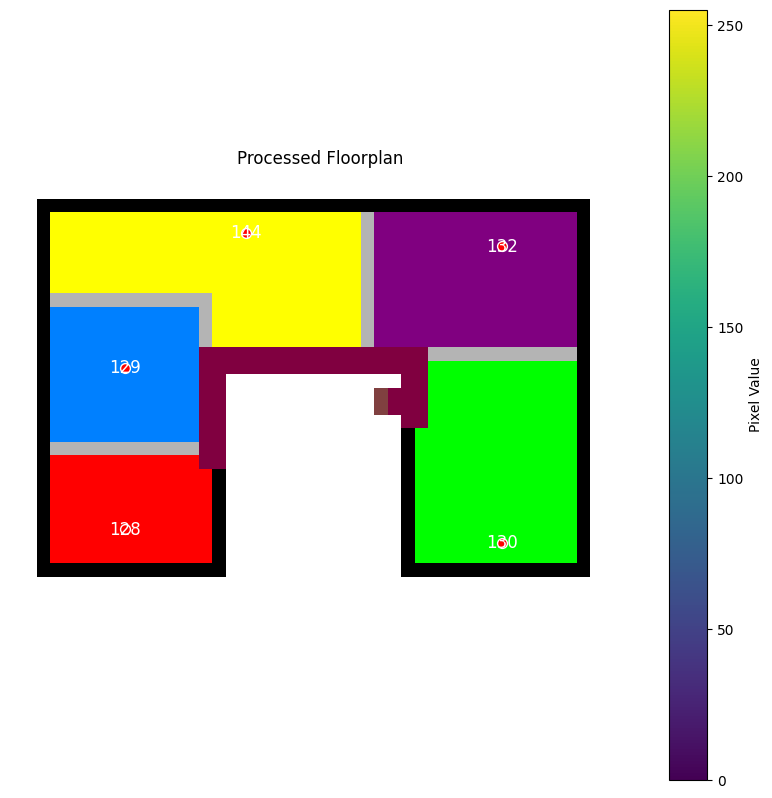

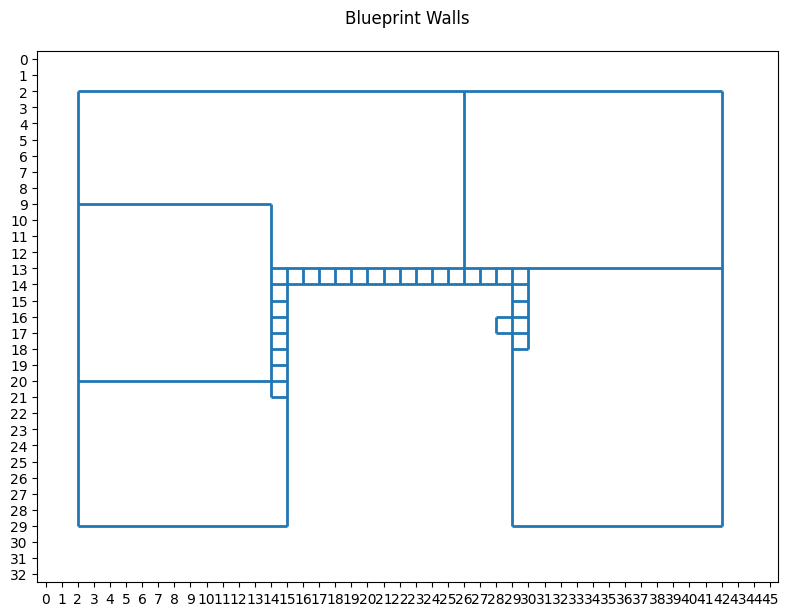

(39, 35, 3)
(4, 5, 129)
(24, 5, 132)
(3, 30, 144)
(14, 30, 130)
(26, 30, 128)


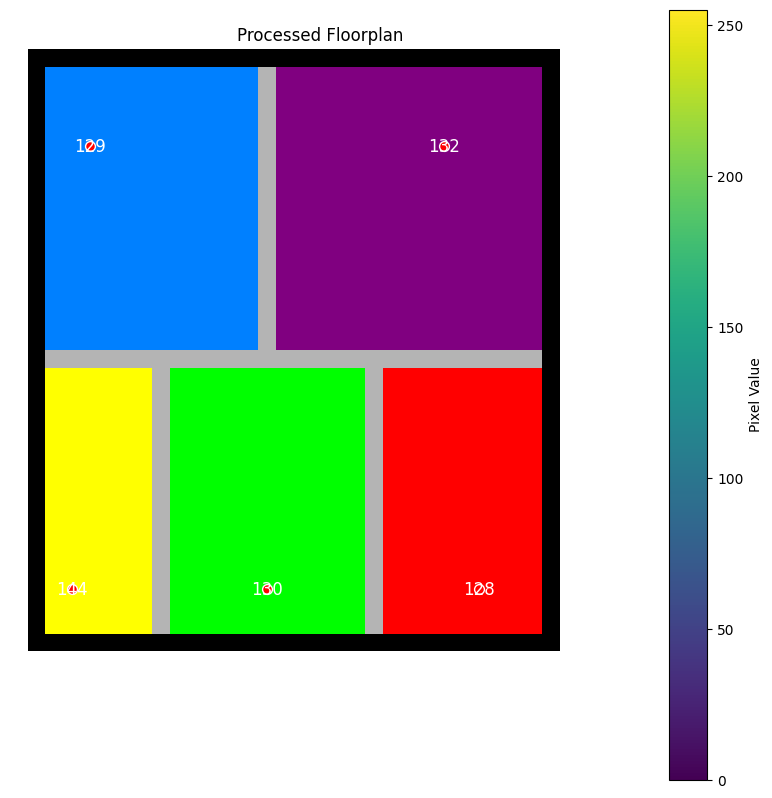

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (33, 1), (33, 30)]
{128: [(24, 30), (26, 30), (31, 20), (18, 20), (29, 20), (22, 20), (20, 20), (17, 21), (17, 24), (17, 30), (28, 30), (17, 27), (19, 30), (30, 30), (33, 23), (33, 20), (33, 26), (26, 20), (32, 30), (24, 20), (33, 29), (21, 30), (23, 30), (17, 23), (17, 20), (17, 26), (28, 20), (27, 30), (32, 20), (19, 20), (17, 29), (30, 20), (33, 22), (33, 28), (33, 25), (25, 30), (18, 30), (29, 30), (21, 20), (20, 30), (31, 30), (23, 20), (22, 30), (27, 20), (17, 22), (17, 28), (17, 25), (33, 21), (33, 24), (33, 30), (25, 20), (33, 27)], 129: [(12, 1), (3, 1), (14, 1), (5, 1), (17, 3), (17, 9), (17, 6), (0, 2), (17, 12), (0, 5), (9, 14), (0, 8), (0, 14), (11, 14), (0, 11), (16, 1), (2, 14), (13, 14), (7, 1), (15, 14), (6, 14)

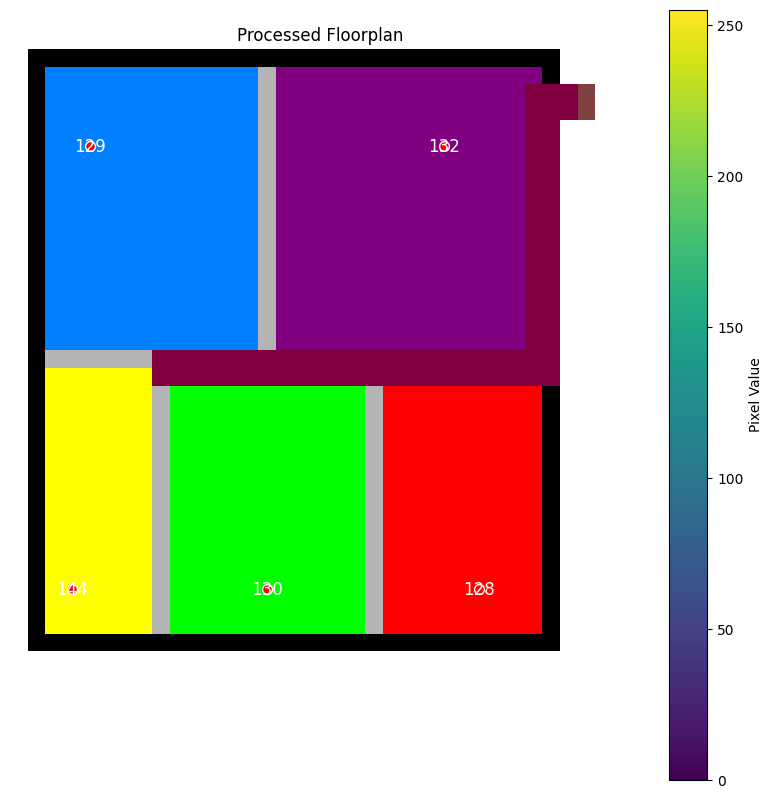

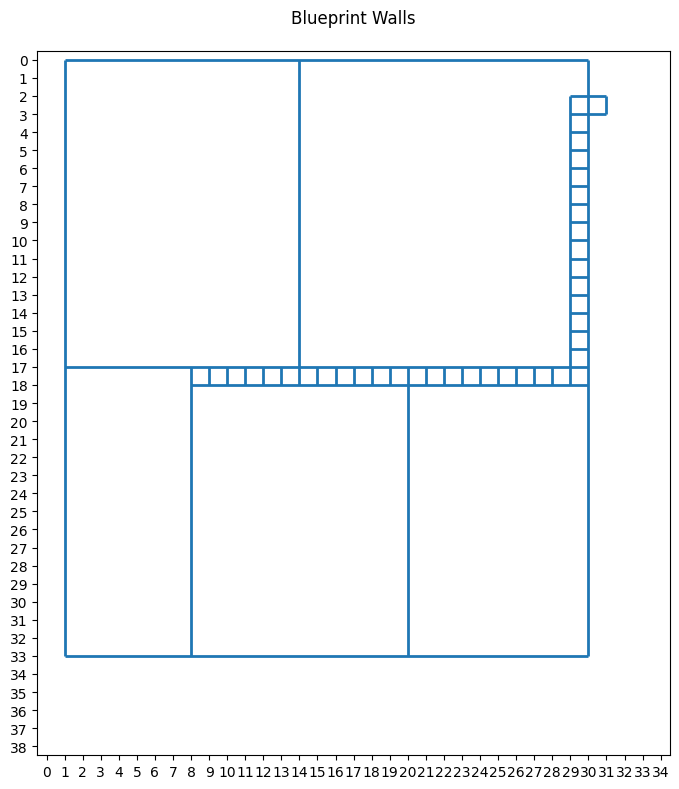

(34, 43, 3)
(5, 5, 128)
(15, 13, 144)
(35, 13, 129)
(4, 27, 130)
(33, 27, 132)


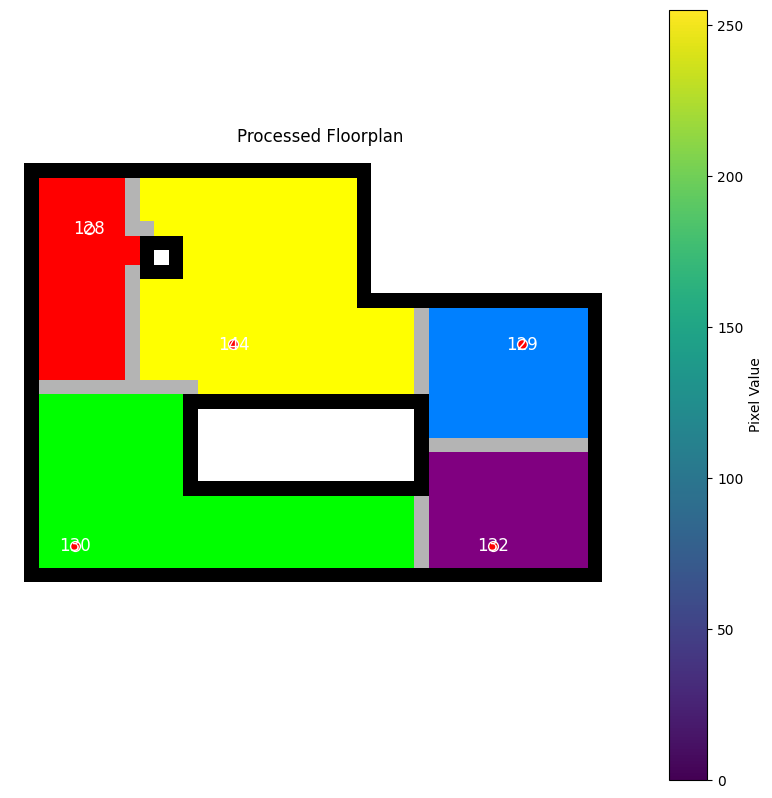

[(1, 1), (1, 24), (6, 9), (6, 11), (8, 9), (8, 11), (10, 24), (10, 40), (17, 12), (17, 28), (23, 12), (23, 28), (29, 1), (29, 40)]
{128: [(12, 1), (3, 1), (14, 1), (5, 1), (8, 9), (9, 8), (1, 6), (11, 8), (1, 3), (16, 4), (2, 8), (13, 8), (16, 1), (16, 7), (7, 1), (15, 8), (4, 8), (5, 9), (9, 1), (11, 1), (8, 8), (1, 2), (2, 1), (10, 8), (1, 5), (13, 1), (6, 1), (16, 3), (1, 8), (15, 1), (16, 6), (7, 9), (4, 1), (12, 8), (3, 8), (14, 8), (5, 8), (8, 1), (1, 1), (10, 1), (1, 4), (16, 2), (1, 7), (16, 5), (16, 8), (6, 9)], 129: [(10, 37), (10, 34), (10, 40), (20, 32), (12, 28), (19, 40), (20, 29), (20, 35), (14, 28), (20, 38), (12, 40), (14, 40), (10, 30), (10, 33), (10, 39), (10, 36), (16, 28), (18, 28), (16, 40), (20, 28), (18, 40), (20, 31), (20, 37), (20, 34), (20, 40), (11, 28), (10, 32), (10, 29), (10, 35), (13, 28), (11, 40), (10, 38), (15, 28), (13, 40), (15, 40), (20, 30), (20, 33), (20, 36), (20, 39), (17, 28), (19, 28), (17, 40), (10, 28), (10, 31)], 130: [(17, 12), (23, 25), 

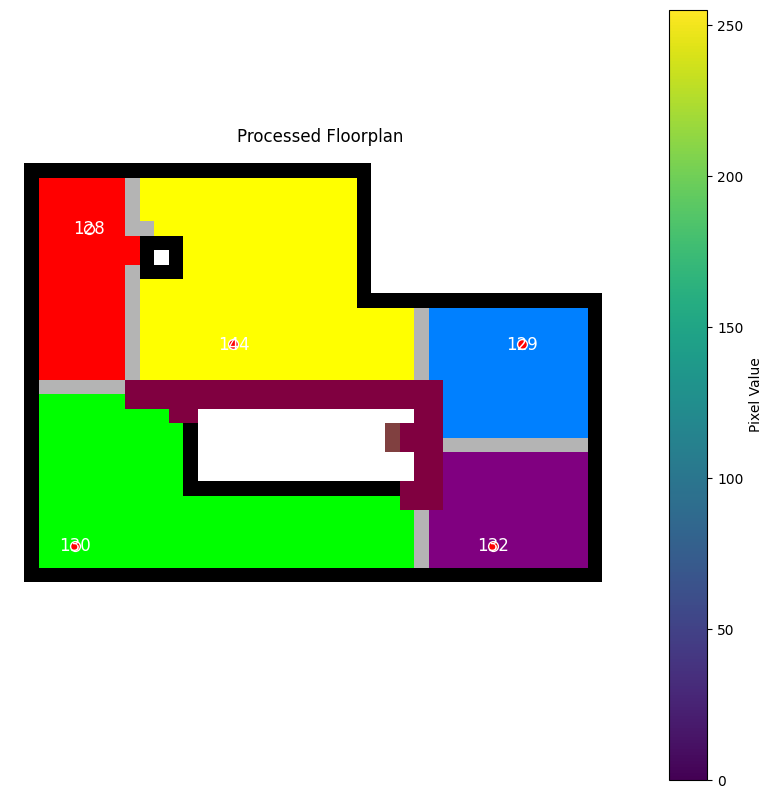

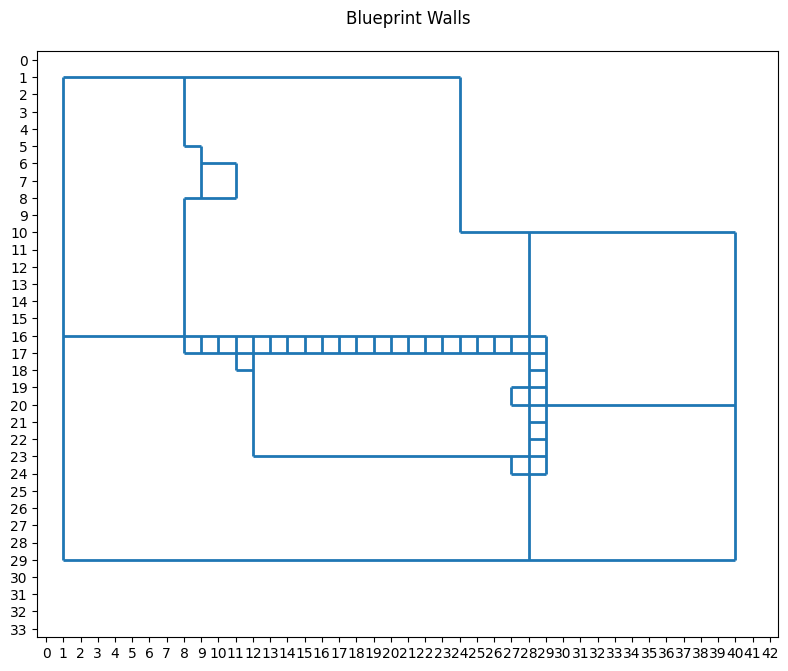

(22, 59, 3)
(31, 4, 130)
(7, 5, 128)
(53, 9, 132)
(8, 13, 129)
(31, 14, 144)


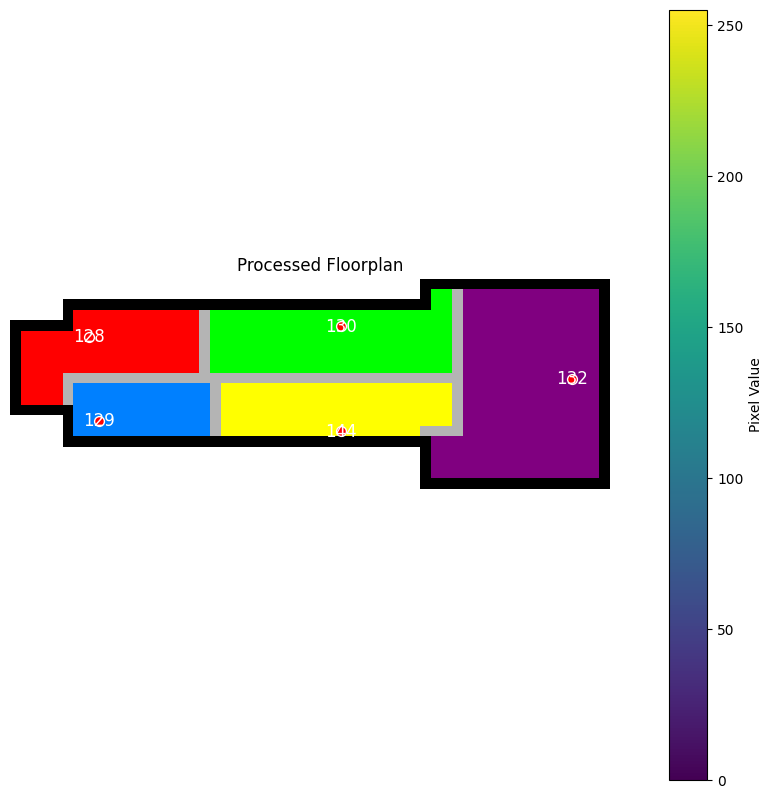

[(0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (2, 5), (2, 39), (4, 0), (4, 5), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (12, 5), (15, 5), (15, 39), (19, 39), (19, 56)]
{128: [(12, 4), (6, 18), (4, 0), (12, 1), (4, 3), (8, 0), (9, 5), (10, 0), (4, 18), (9, 8), (9, 14), (11, 5), (8, 18), (9, 11), (9, 17), (2, 5), (2, 11), (2, 8), (2, 14), (2, 17), (12, 0), (4, 2), (12, 3), (4, 5), (5, 0), (3, 18), (9, 7), (5, 18), (9, 10), (9, 16), (10, 5), (9, 13), (2, 7), (2, 10), (2, 16), (7, 0), (2, 13), (12, 2), (12, 5), (4, 1), (7, 18), (3, 5), (4, 4), (9, 0), (9, 9), (11, 0), (9, 6), (9, 12), (9, 15), (2, 9), (9, 18), (2, 6), (2, 12), (2, 18), (6, 0), (2, 15)], 129: [(12, 19), (9, 5), (14, 19), (9, 8), (11, 5), (9, 14), (9, 11), (9, 17), (13, 5), (15, 5), (15, 11), (15, 8), (15, 14), (15, 17), (9, 7), (9, 10), (9, 16), (10, 5), (9, 13), (9, 19), (11, 19), (

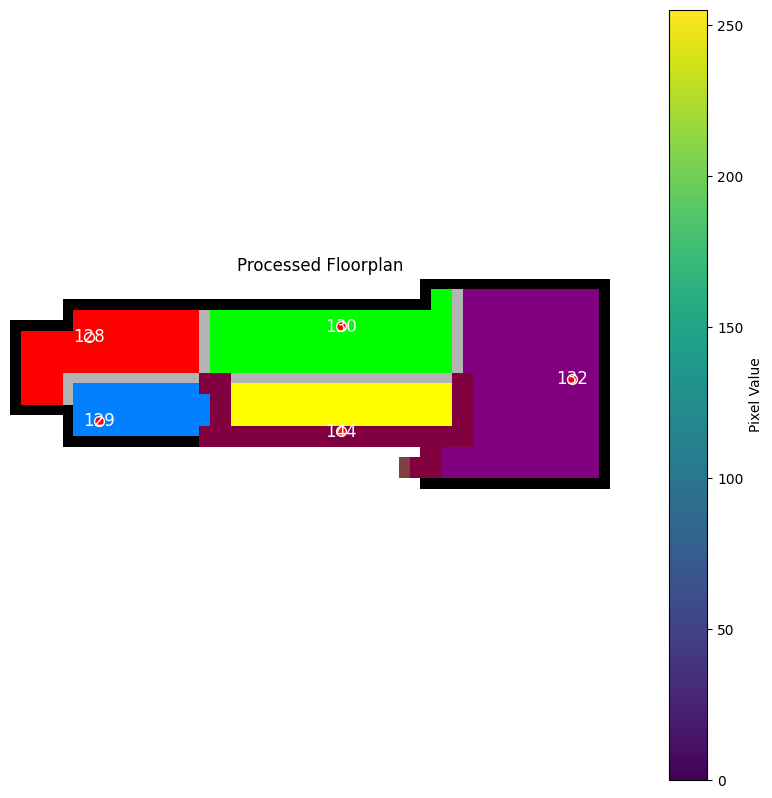

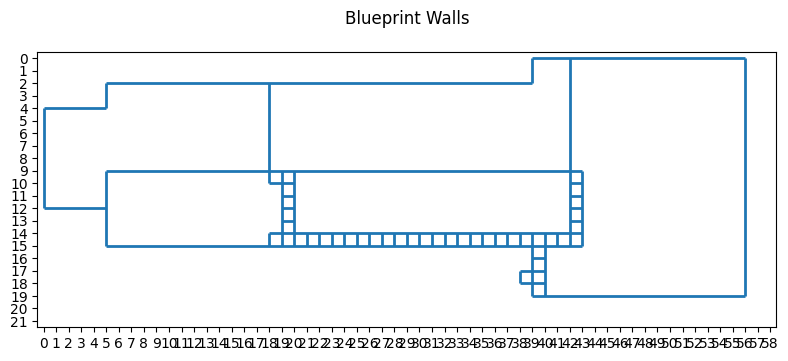

(53, 70, 3)
(34, 8, 144)
(3, 11, 130)
(3, 36, 128)
(60, 36, 129)
(23, 48, 136)


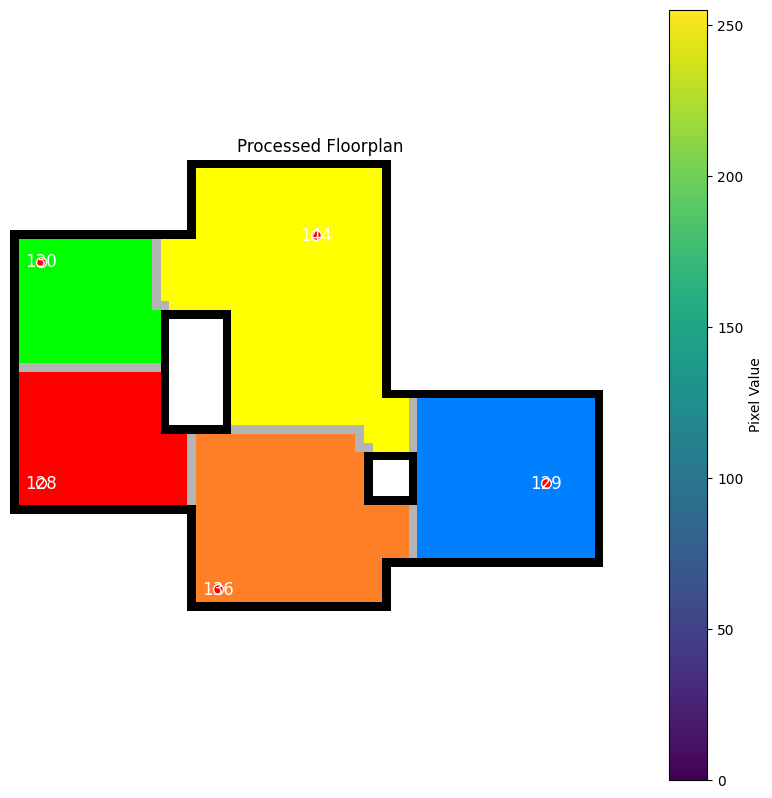

[(0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (8, 0), (8, 20), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (17, 17), (17, 24), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (26, 42), (26, 66), (27, 0), (28, 0), (29, 0), (30, 0), (30, 17), (30, 24), (31, 0), (32, 0), (33, 0), (33, 40), (33, 45), (34, 0), (35, 0), (36, 0), (37, 0), (38, 0), (38, 40), (38, 45), (39, 0), (39, 20), (45, 42), (45, 66), (50, 20), (50, 42)]
{128: [(23, 4), (39, 12), (39, 18), (23, 1), (23, 7), (29, 17), (31, 20), (37, 0), (23, 10), (23, 16), (28, 0), (38, 20), (23, 13), (30, 0), (32, 0), (30, 18), (39, 2), (33, 20), (24, 17), (39, 8), (39, 5), (39, 11), (35, 20), (23, 0), (26, 17), (34, 0), (39, 14), (23, 3), (23, 9), (36, 0), (39, 17), (23, 6), (23, 12), (39, 20), (27, 0), (23, 15

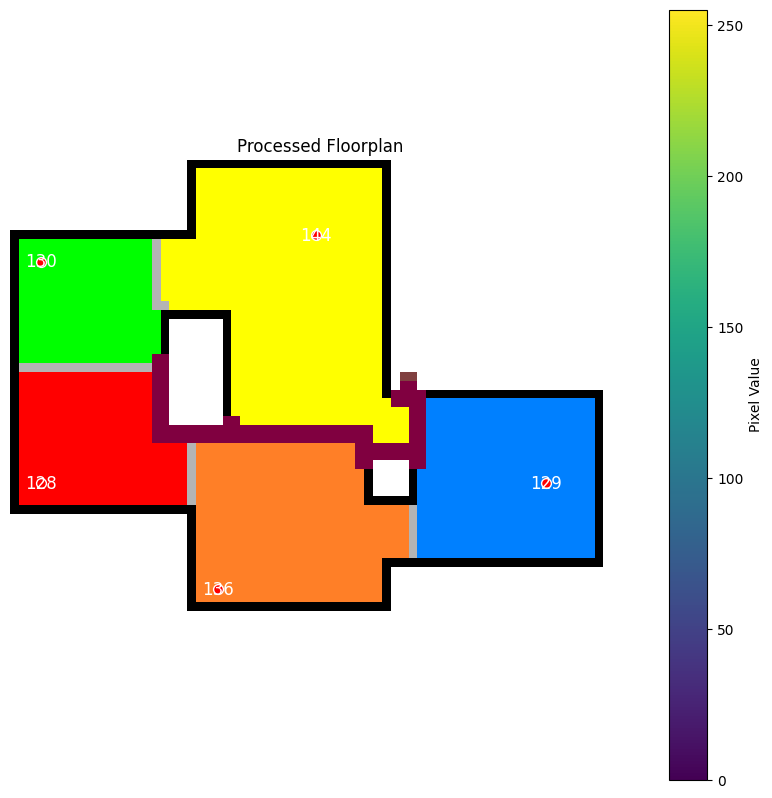

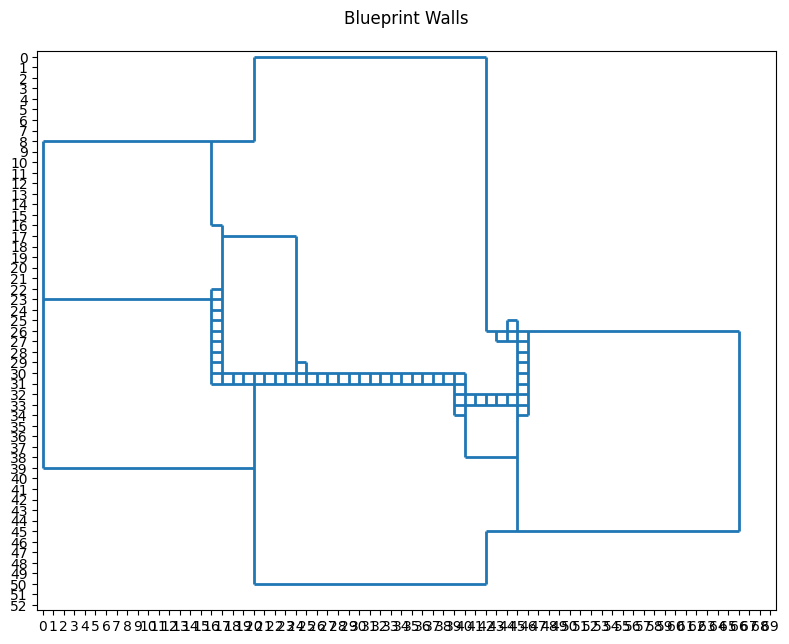

(36, 36, 3)
(28, 3, 129)
(2, 13, 132)
(30, 16, 130)
(13, 28, 144)
(31, 31, 128)


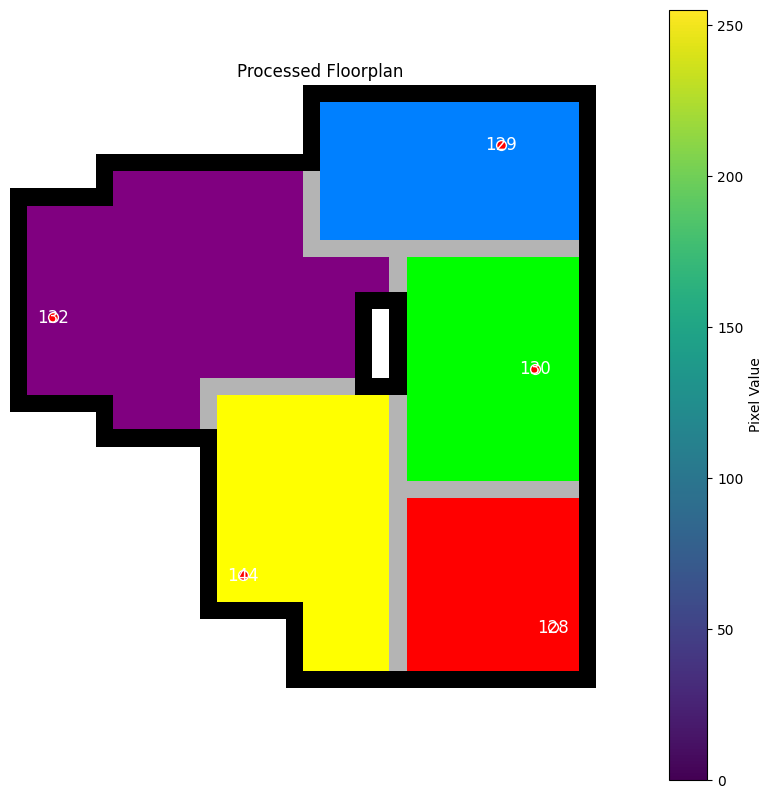

[(0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (4, 5), (4, 17), (6, 0), (6, 5), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (12, 20), (12, 22), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (17, 20), (17, 22), (18, 0), (18, 5), (20, 5), (20, 11), (30, 11), (30, 16), (34, 16), (34, 33)]
{128: [(24, 33), (26, 33), (34, 25), (23, 22), (23, 28), (34, 22), (34, 28), (23, 25), (23, 31), (34, 31), (27, 22), (28, 33), (30, 33), (25, 22), (32, 33), (29, 22), (31, 22), (23, 24), (23, 30), (34, 24), (34, 30), (23, 27), (23, 33), (34, 27), (34, 33), (27, 33), (33, 22), (24, 22), (25, 33), (26, 22), (23, 23), (29, 33), (34, 23), (23, 26), (31, 33), (34, 26), (23, 29), (34, 29), (23, 32), (28, 22), (34, 32), (30, 22), (32, 22), (33, 33)], 129: [(0, 30), (2, 33), (7, 17), (6, 33), (4, 33), (9, 17), (9, 20), (0, 17), (0, 23), (9, 26), (9, 23), (0, 20), (2, 17), (0, 26), (8, 33), (9, 29), (0

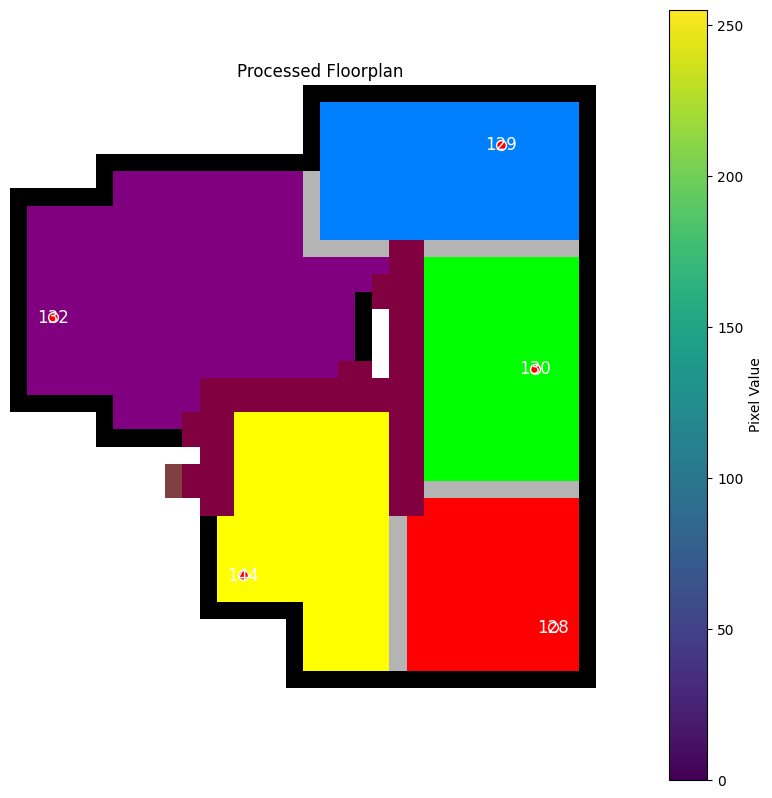

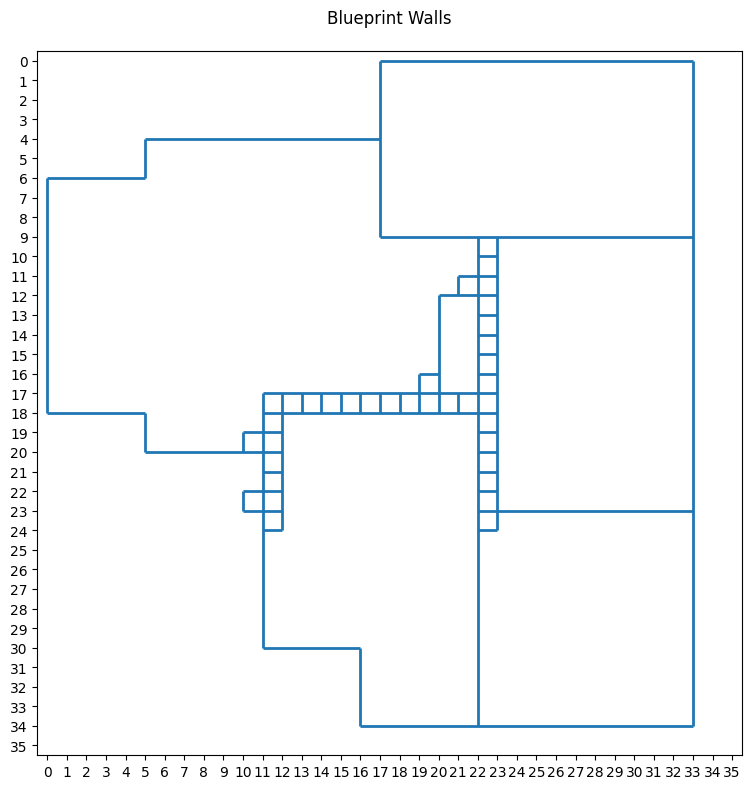

(47, 39, 3)
(8, 4, 129)
(27, 4, 144)
(27, 20, 132)
(5, 39, 128)
(29, 39, 130)


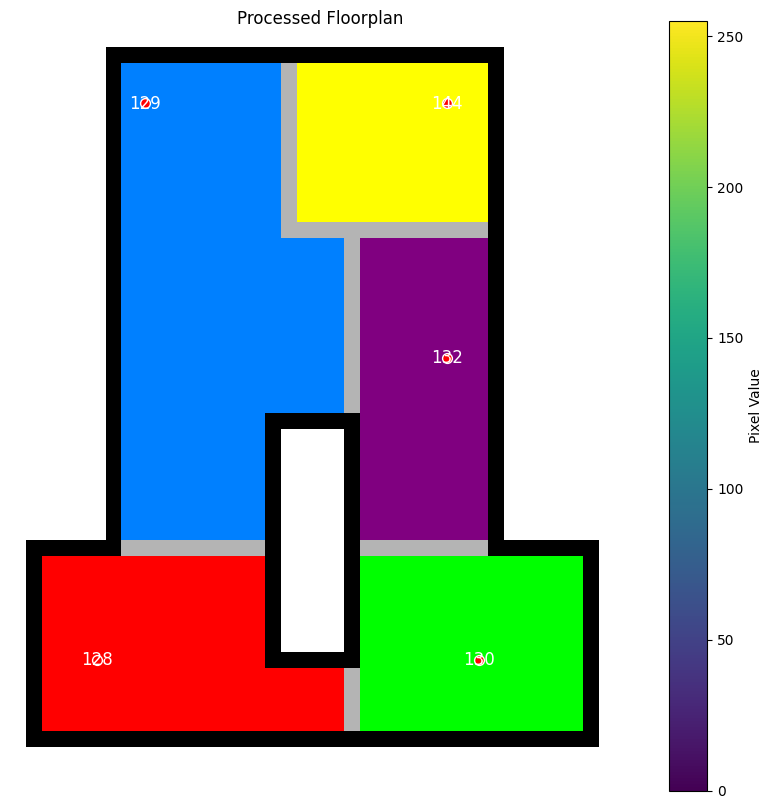

[(1, 6), (1, 30), (24, 16), (24, 21), (32, 1), (32, 6), (32, 30), (32, 36), (39, 16), (39, 21), (44, 1), (44, 36)]
{128: [(39, 18), (34, 1), (39, 21), (36, 1), (34, 16), (36, 16), (44, 2), (32, 6), (44, 5), (32, 3), (32, 9), (44, 11), (44, 8), (44, 14), (32, 12), (41, 21), (38, 1), (32, 15), (43, 21), (44, 17), (44, 20), (40, 1), (38, 16), (39, 20), (39, 17), (42, 1), (44, 4), (32, 2), (33, 1), (44, 1), (32, 5), (32, 11), (44, 7), (35, 1), (32, 8), (32, 14), (33, 16), (39, 1), (44, 10), (35, 16), (44, 13), (44, 16), (44, 19), (39, 16), (40, 21), (39, 19), (37, 1), (37, 16), (32, 1), (43, 1), (41, 1), (44, 6), (32, 4), (44, 3), (44, 9), (32, 7), (32, 13), (42, 21), (32, 10), (32, 16), (44, 12), (44, 15), (44, 18), (44, 21)], 129: [(15, 21), (7, 17), (10, 6), (17, 21), (9, 17), (32, 12), (1, 15), (24, 17), (27, 6), (3, 6), (12, 18), (32, 14), (1, 8), (29, 6), (16, 6), (1, 17), (24, 19), (26, 16), (18, 21), (22, 21), (12, 20), (3, 17), (28, 16), (32, 7), (32, 16), (1, 10), (6, 6), (24, 21

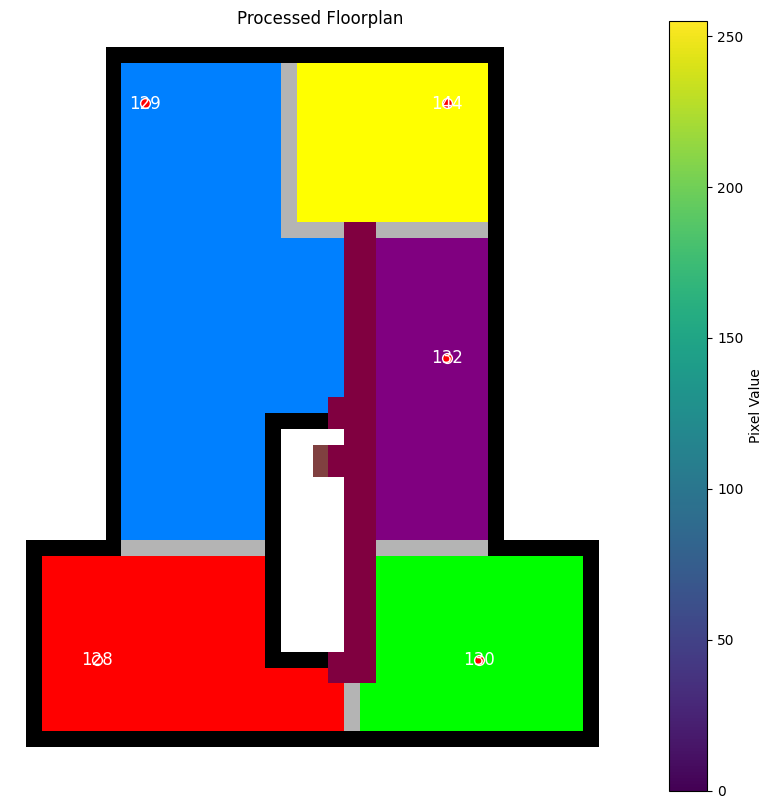

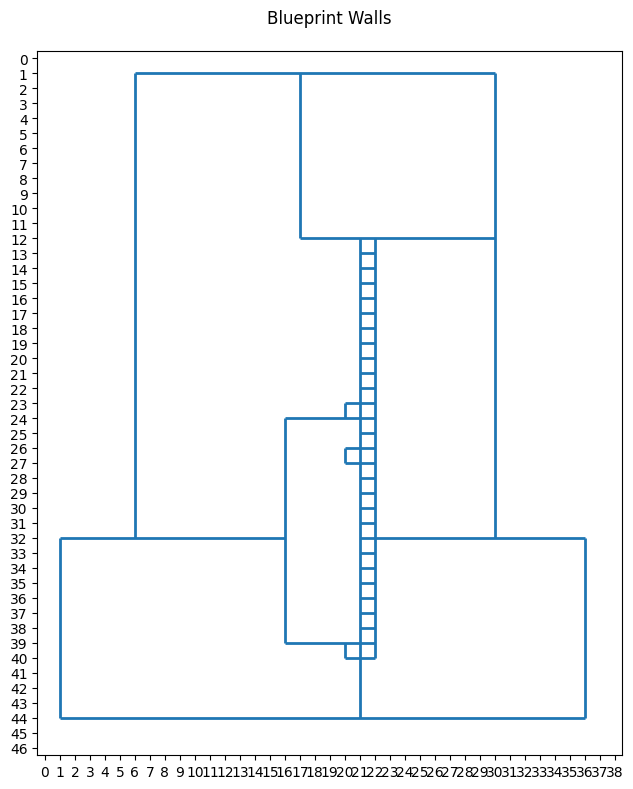

In [5]:
floorplans_int = []
all_seeds = []
from floor import FloorPlan



for floorplan in floorplans:
    floorplan_int, seed_list = image_to_int(floorplan)
    fp = FloorPlan(floorplan_int, seed_list)
    print(floorplan.shape)
    # Optionally plot the floorplan with seed locations
    # plot_floorplan(floorplan_int, seed_list)
    
    floorplans_int.append(floorplan_int)
    #fp.grid = make_organic_walls(fp.grid)

    #fp.generate_wfc()
    #fp.visualize()
    fp.grow_regions(rectangular=True)
    fp.show()
    # Optionally generate mapping rectangles, fill rooms and refine walls
    #fp.generate_mapping_rectangles()
    fp.generate_stairs()
    fp.generate_corridors()
    
    # Display the result
    fp.show()
    #print(fp.grid)
    #grid_svg = Wall.convert_to_3x3(fp.grid.astype(int).tolist())

    converted_simple = np.array([[1 if x in {1, 21, 18, 19} else 0 for x in row] for row in fp.grid.astype(int)])
    horiz, vert = extract_wall_segments(converted_simple)
    plot_blueprint_walls(horiz, vert, *converted_simple.shape)

    
    #generate_svg(grid_svg, cell_size=10, output_file="complex_layout.svg")


In [6]:
"""
grid_simple = [
    [0, 0, ],
    [0, 0, ],
]
fp = FloorPlan(np.array(grid_simple), seeds=[])
    # Optionally plot the floorplan with seed locations
    # plot_floorplan(floorplan_int, seed_list)
    

fp.show()
fp.generate_wfc()


fp.show()
"""


'\ngrid_simple = [\n    [0, 0, ],\n    [0, 0, ],\n]\nfp = FloorPlan(np.array(grid_simple), seeds=[])\n    # Optionally plot the floorplan with seed locations\n    # plot_floorplan(floorplan_int, seed_list)\n    \n\nfp.show()\nfp.generate_wfc()\n\n\nfp.show()\n'